# creating basic model
- with character level tokenization

steps:-
- [X] tokenization
- [X] make a dataset pipeline
- [X] create a model
- [X] define/choose some metrics for evaluation
- [X] train the model
- [X] evalulate the model 


note:-
- we don't accept symbols other than " " in tokenization

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

## loading the data

In [25]:
train_file_path = "datasets/color_name_to_colors.csv"
val_file_path = "datasets/wikipedia_x11_colors.csv"

train_data=pd.read_csv(train_file_path) # loading the training data
val_data=pd.read_csv(val_file_path) # loading the validation data

print("len of training data:", len(train_data))
print("len of validation data:", len(val_data))

len of training data: 755
len of validation data: 144


In [26]:
# checking if data is null
print(train_data.isnull().sum())
print(val_data.isnull().sum())

Name    0
R       0
G       0
B       0
dtype: int64
Name    0
R       0
G       0
B       0
dtype: int64


In [27]:
# preprocessing for colors without any name
train_data['Name']=train_data['Name'].map(lambda x:x.strip(" ").lower())
val_data['Name']=val_data['Name'].map(lambda x:x.strip(" ").lower())

In [28]:
# remove empty name examples
train_data = train_data[(train_data['Name']!='')]
val_data = val_data[(val_data['Name']!='')]

In [29]:
# clip color values
train_data[['R','G','B']] = train_data[['R','G','B']].clip(0,255)
val_data[['R','G','B']] = val_data[['R','G','B']].clip(0,255)

In [30]:
# dataframe to numpy array conversion

train_data = train_data.to_numpy()
val_data = val_data.to_numpy()

In [31]:
# tokenization dicts

TOKENS = {chr(i) for i in range(97,122+1)}  # add lower case characters tokens
TOKENS.add(" ")     # add space token
for i in range(10): TOKENS.add(str(i))    # add digits tokens

token_to_idx = {token:idx for idx,token in enumerate(TOKENS)}
idx_to_token = {idx:token for idx,token in enumerate(TOKENS)}
# token_to_idx

In [32]:
def tokenize(name):
    """ tokenize single name """
    return [token_to_idx[char] for char in name]

def one_hot_encode(tokens,num_classes):
    return tf.keras.utils.to_categorical(tokens,num_classes=num_classes)

def add_padding(one_hot_vectors,num_classes,max_num_tokens):
    ''' one_hot_vectors:np.array shape:(tokens,len(all_tokens)) '''
    num_of_padding = max_num_tokens-len(one_hot_vectors)
    padding = []
    
    for _ in range(num_of_padding):
        padding.append(np.zeros([num_classes]))
    padding = np.array(padding)

    # print(max_num_tokens)
    # print(num_of_padding)
    # print(padding.shape)
    # print(one_hot_vectors.shape)

    return np.r_[padding,one_hot_vectors] if len(padding)>0 else one_hot_vectors

def preprocess(names):
    """ names: [name,name,name,...] """
    
    max_num_tokens=0
    one_hots_list = []

    for name in names:
        name = name.lower()
        tokens = tokenize(name)
        one_hot_vectors = one_hot_encode(tokens,len(TOKENS))
        if len(tokens)>max_num_tokens:   max_num_tokens=len(tokens)
        one_hots_list.append(one_hot_vectors)
    
    for i in range(len(one_hots_list)):
        # we need to add padding so that all the examples have same number of tokens
        one_hots = one_hots_list[i]
        one_hots_list[i] = add_padding(one_hots,len(TOKENS),max_num_tokens)

    return np.array(one_hots_list)


train_name_tokens = preprocess(train_data[:,0])
val_name_tokens = preprocess(val_data[:,0])

In [33]:
train_colors = train_data[:,1:].astype("uint8")
val_colors = val_data[:,1:].astype("uint8")

In [34]:
def normalize(tokens,color):
    color=tf.cast(color,dtype="float32")/255.0
    return tokens,color
def get_tf_dataset(names_tokens,colors,bs=32,shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((names_tokens,colors))
    if shuffle: ds=ds.shuffle(len(colors))
    ds = ds.map(normalize,num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(bs,num_parallel_calls=tf.data.AUTOTUNE)
    return ds

train_ds = get_tf_dataset(train_name_tokens,train_colors,bs=32)
train_ds

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 29, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [35]:
for data in train_ds.take(1):
    print(data[0].shape)
    print(data[1].shape)

(32, 29, 37)
(32, 3)


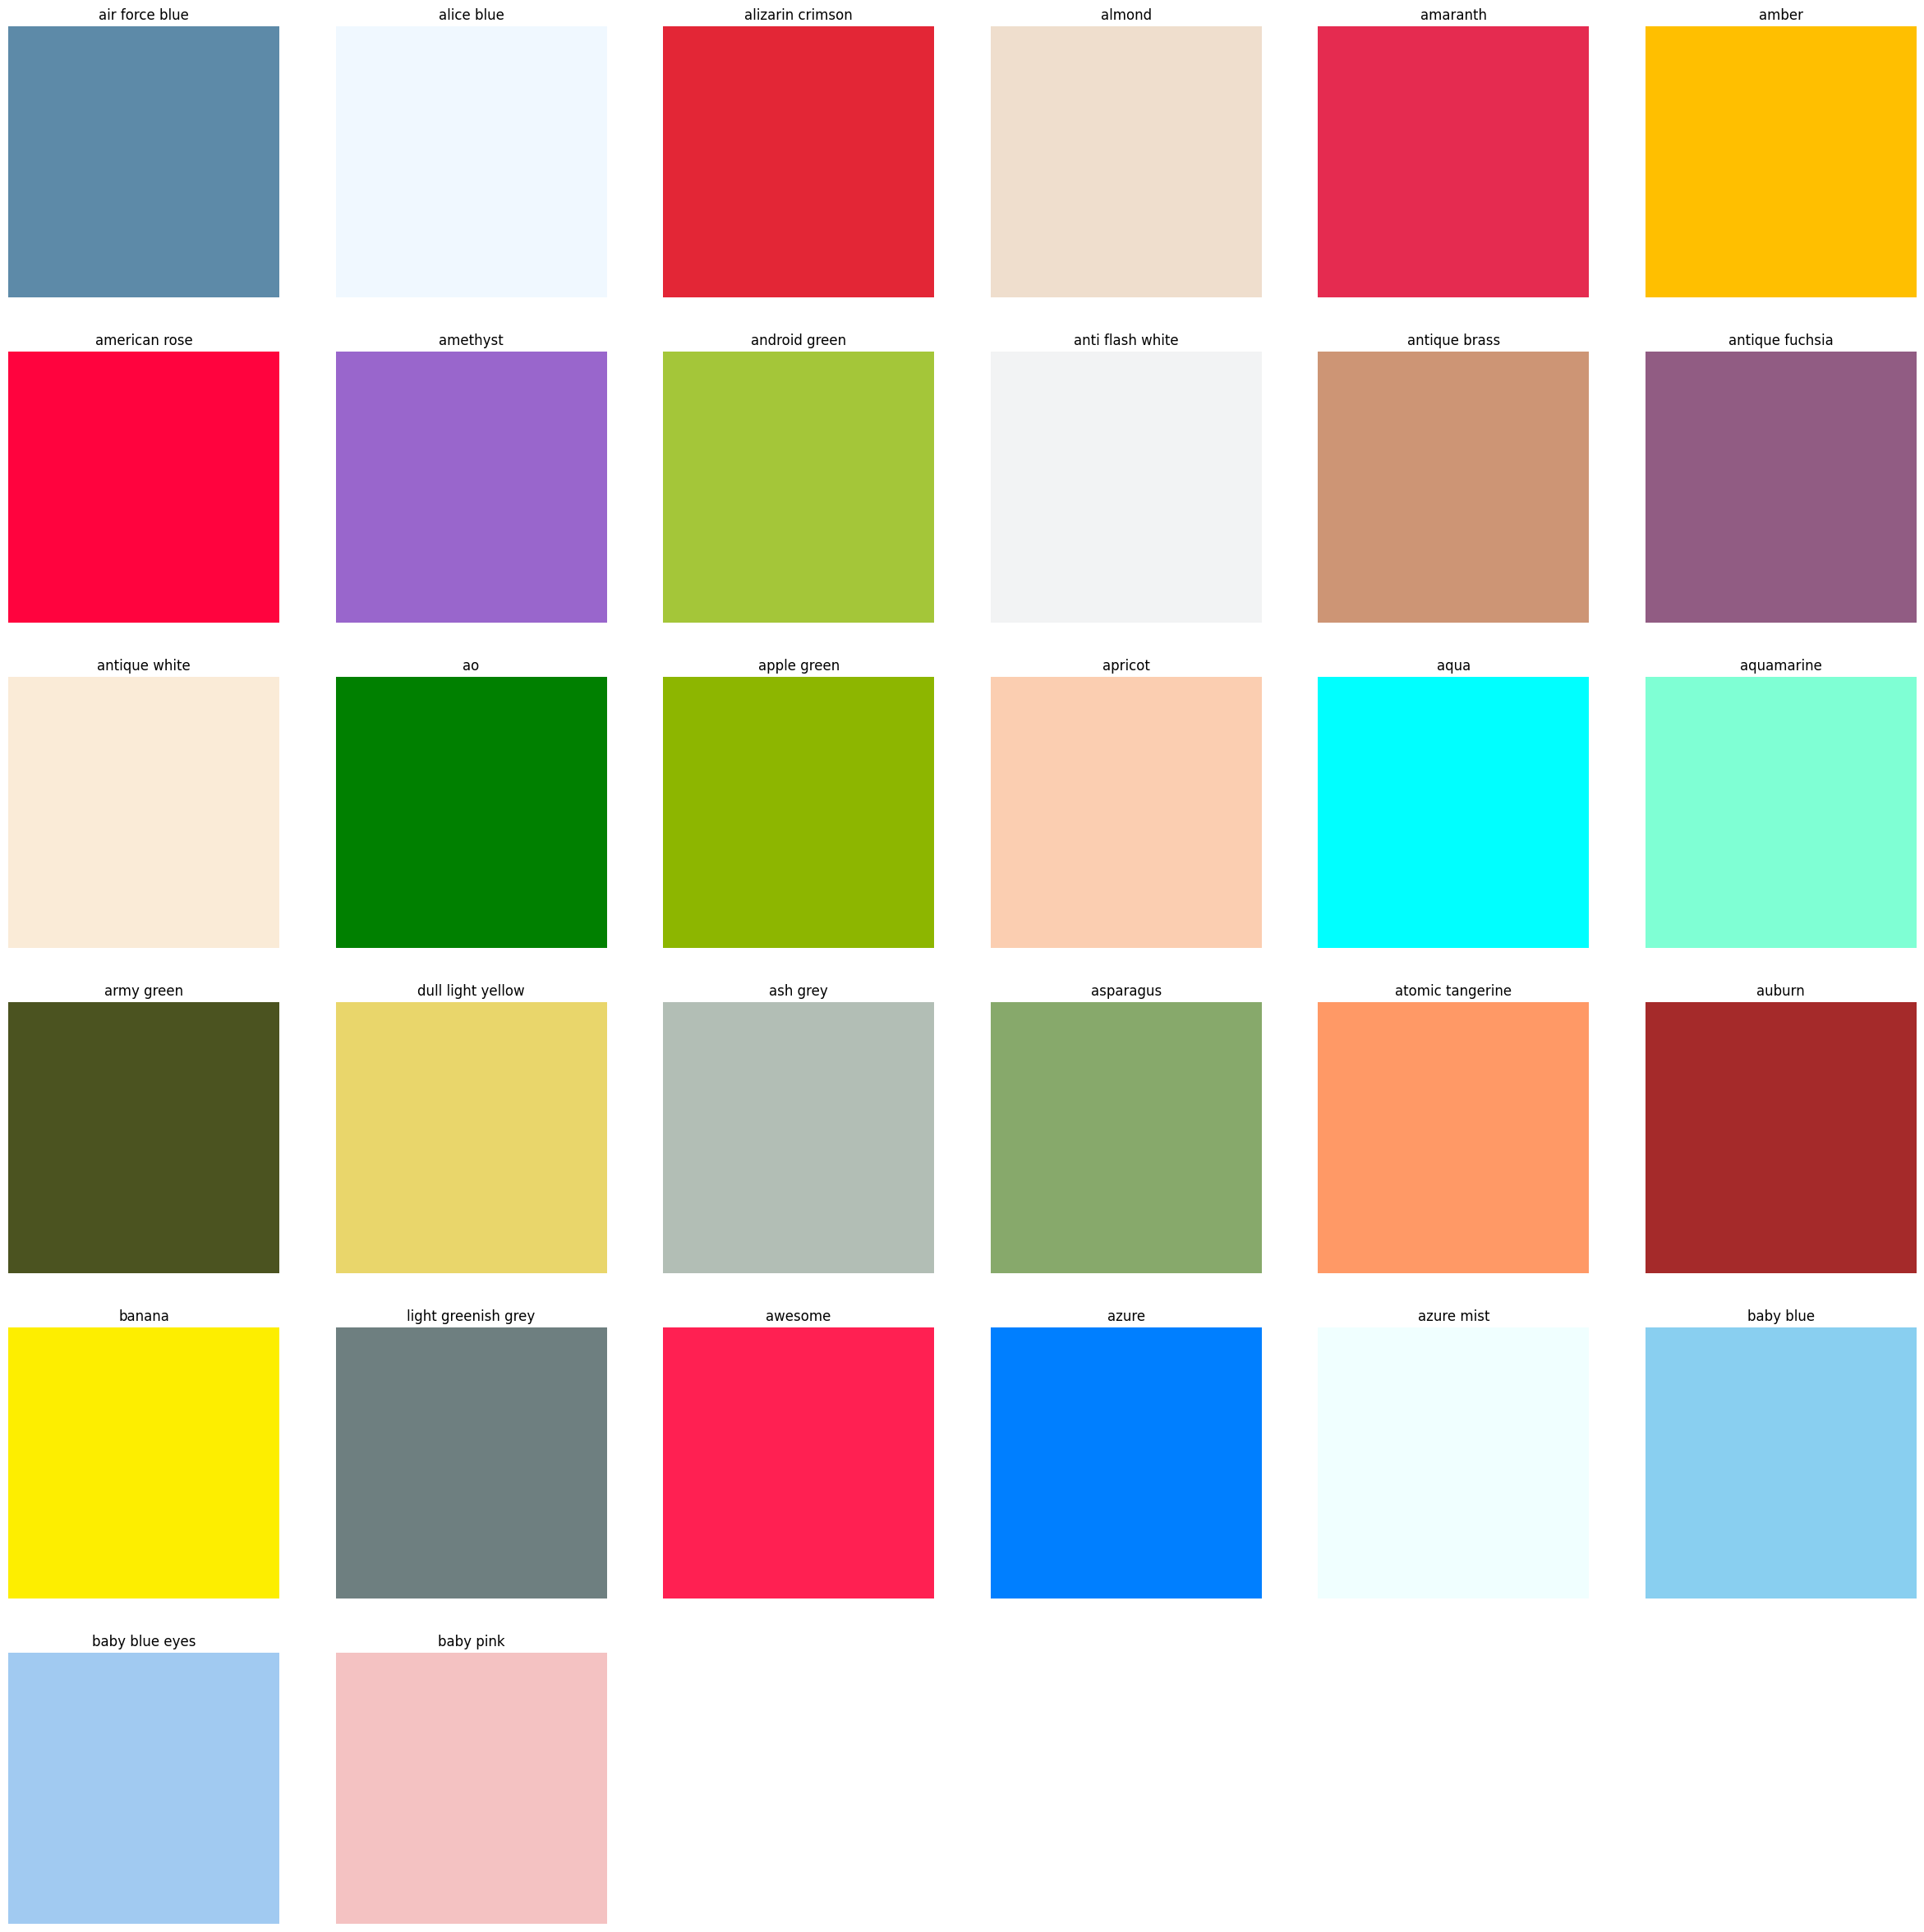

In [36]:
def one_hot_tokens_to_str(tokens):
    # print("see")
    name_str=""
    for idx,token in enumerate(tokens):
        token_idx = np.argmax(token)
        if(token.sum()==0):    continue   # skip padding tokens
        name_str+=idx_to_token[token_idx]
    return name_str

def plot_single_example(name_str,color):
    plt.axis("off")
    plt.title(name_str)
    plt.imshow(color.reshape([1,1,3]))



for data in train_ds.take(1):
    tokens=data[0].numpy()
    colors=data[1].numpy()
    
    cols=6
    rows=math.ceil(len(tokens)/cols)
    size=5

    fig=plt.figure(figsize=(size*rows,size*cols))

    for idx in range(len(tokens)):
        name_str=one_hot_tokens_to_str(tokens[idx])
        color=(colors[idx]*255).astype("uint8")
        fig.add_subplot(rows,cols,idx+1)    
        plot_single_example(name_str,color)
    
    plt.show()

## Defining an Simple Model

In [37]:
from tensorflow.keras import layers,Model

def get_colgen_1():
    x_input = layers.Input(shape=(None,len(TOKENS)))
    x = layers.GRU(units=32,return_sequences=True)(x_input)
    x = layers.GRU(units=64,return_sequences=True)(x)
    x = layers.GRU(units=128,return_sequences=False)(x)
    x = layers.Dense(64,activation='relu')(x)
    x = layers.Dense(32,activation='relu')(x)
    x = layers.Dense(3,activation='sigmoid')(x)
    model = Model(x_input,x,name="Colgen-1")
    return model

model = get_colgen_1()
model.summary()


Model: "Colgen-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 37)]        0         
                                                                 
 gru (GRU)                   (None, None, 32)          6816      
                                                                 
 gru_1 (GRU)                 (None, None, 64)          18816     
                                                                 
 gru_2 (GRU)                 (None, 128)               74496     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99 

## Compiling the Model

In [48]:
def euclidean_distance(y_true,y_pred):
    '''
        y_true shape:(batch_size,3)
        y_pred shape:(batch_size,3)
    '''

    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true-y_pred),axis=-1)))

In [49]:
model = get_colgen_1()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="MSE",metrics=["acc",euclidean_distance])

## Training the Model

In [50]:
bs=32
train_ds = get_tf_dataset(train_name_tokens,train_colors,bs=bs,shuffle=True)
val_ds = get_tf_dataset(val_name_tokens,val_colors,bs=bs)
history = model.fit(train_ds,validation_data=val_ds,epochs=100)

Epoch 1/100
24/24 [==============================] - 11s 88ms/step - loss: 0.0996 - acc: 0.5942 - euclidean_distance: 0.5166 - val_loss: 0.1138 - val_acc: 0.5278 - val_euclidean_distance: 0.5541
Epoch 2/100
24/24 [==============================] - 1s 41ms/step - loss: 0.0923 - acc: 0.5981 - euclidean_distance: 0.4938 - val_loss: 0.1038 - val_acc: 0.6597 - val_euclidean_distance: 0.5208
Epoch 3/100
24/24 [==============================] - 1s 41ms/step - loss: 0.0854 - acc: 0.6817 - euclidean_distance: 0.4724 - val_loss: 0.1002 - val_acc: 0.7222 - val_euclidean_distance: 0.5050
Epoch 4/100
24/24 [==============================] - 1s 41ms/step - loss: 0.0776 - acc: 0.7188 - euclidean_distance: 0.4466 - val_loss: 0.0907 - val_acc: 0.7222 - val_euclidean_distance: 0.4776
Epoch 5/100
24/24 [==============================] - 1s 43ms/step - loss: 0.0729 - acc: 0.7334 - euclidean_distance: 0.4283 - val_loss: 0.0876 - val_acc: 0.7083 - val_euclidean_distance: 0.4671
Epoch 6/100
24/24 [==========

## Evaluating the Model

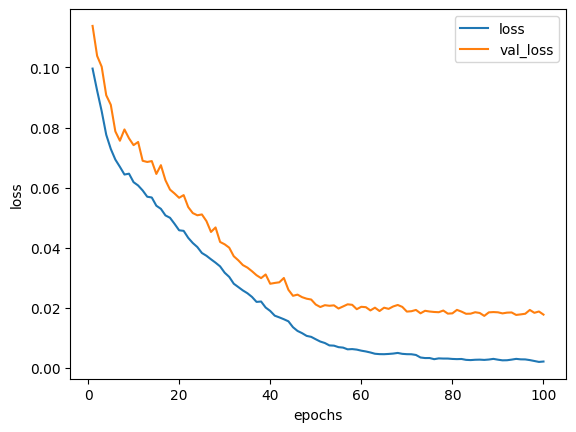

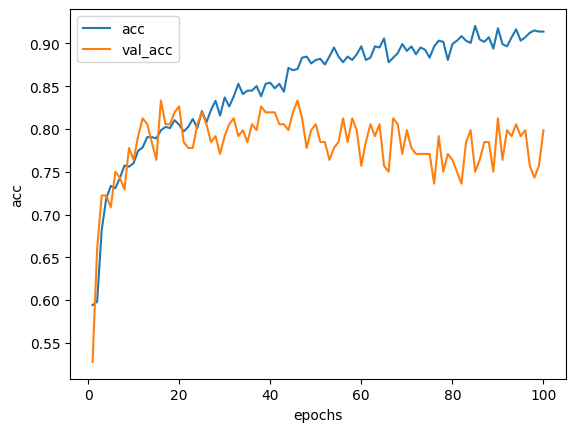

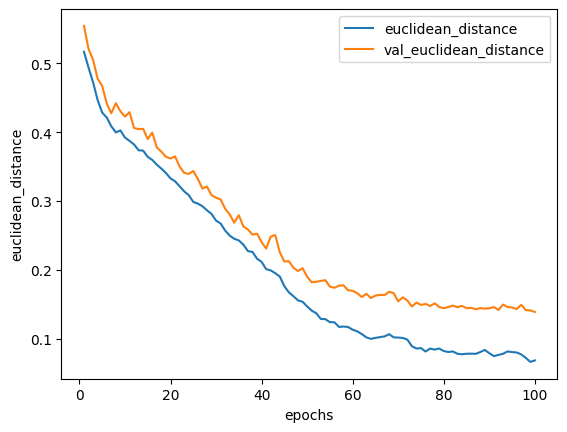

In [52]:
def plot_history(hist,key):
    epochs = list(range(1,len(hist[key])+1))
    plt.figure()
    plt.plot(epochs,hist[key] ,label=key)
    plt.plot(epochs,hist["val_"+key],label="val_"+key)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel(key)
    plt.show()

plot_history(history.history,"loss")
plot_history(history.history,"acc")
plot_history(history.history,"euclidean_distance")

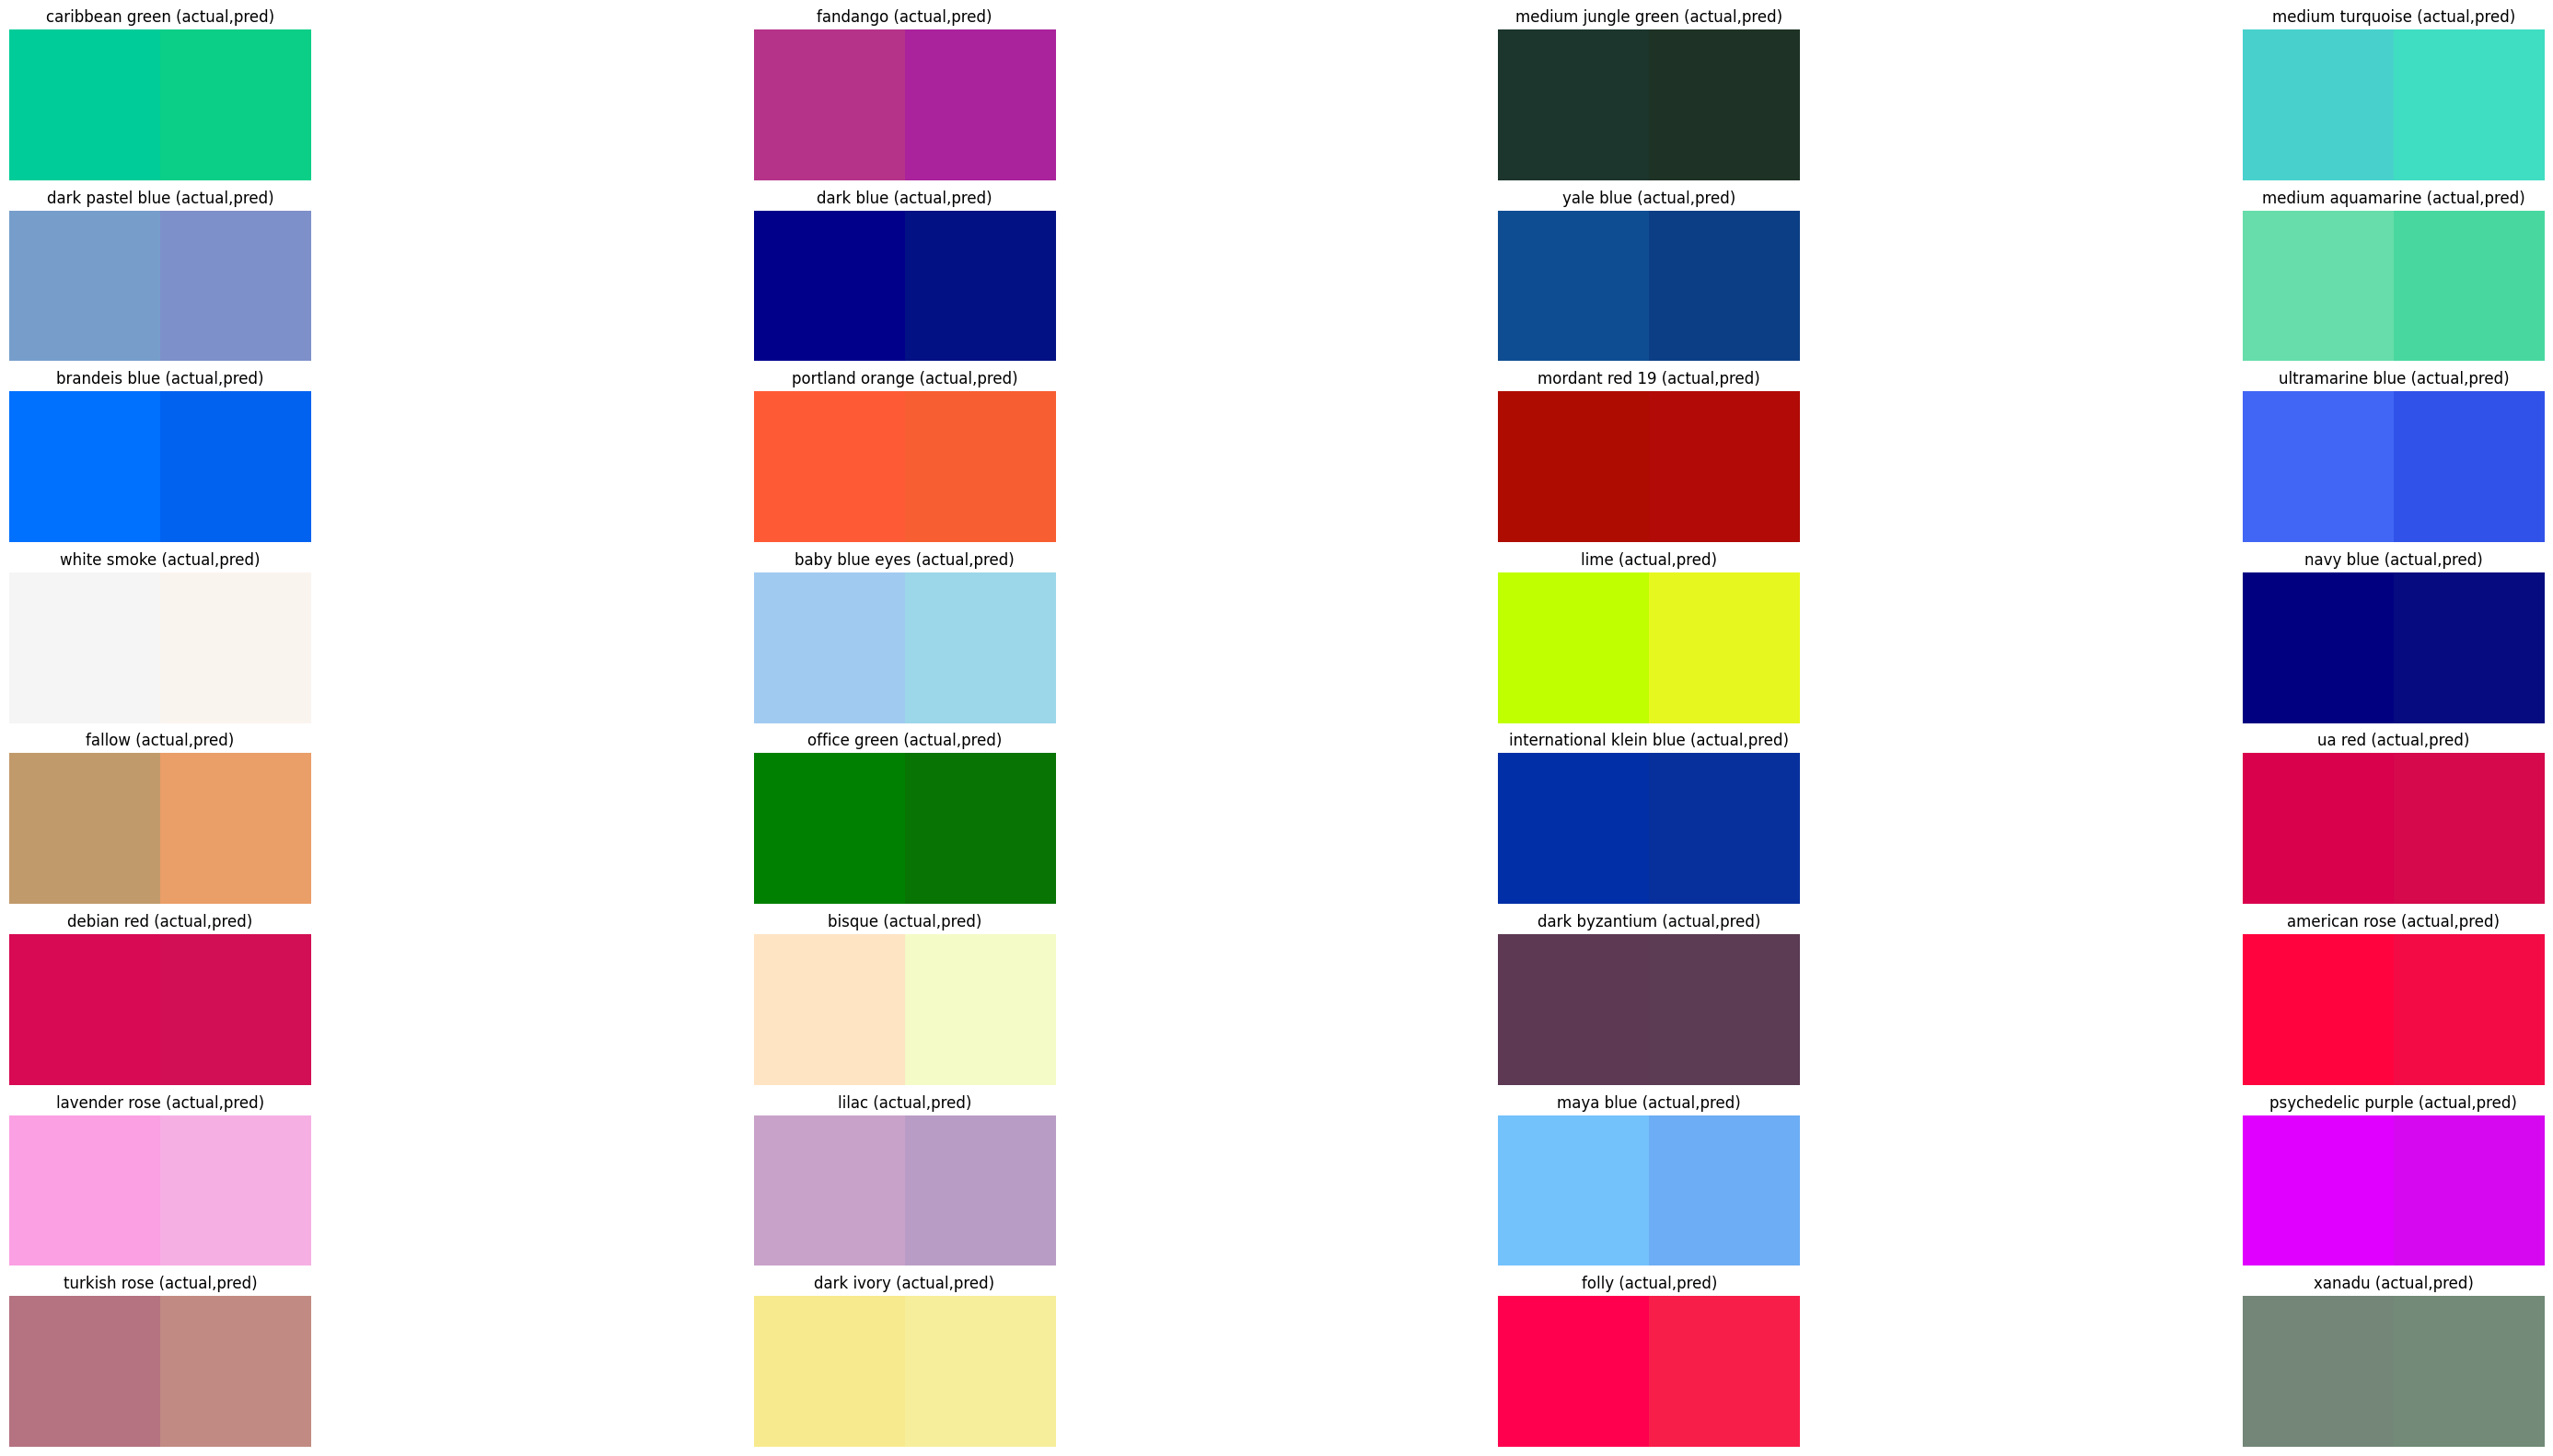

In [53]:
def plot_compare_example(name_str,color,pred_color):
    plt.axis("off")
    plt.title(name_str)
    plt.imshow(np.concatenate([color.reshape([1,1,3]),pred_color.reshape([1,1,3])],axis=1))


for data in train_ds.take(1):
    tokens=data[0].numpy()
    colors=data[1].numpy()
    y_preds=model.predict(tokens,verbose=0)
    
    cols=4
    rows=math.ceil(len(tokens)/cols)
    size=5

    fig=plt.figure(figsize=(size*rows,size*cols))

    for idx in range(len(tokens)):
        name_str=one_hot_tokens_to_str(tokens[idx])
        color=(colors[idx]*255).astype("uint8")
        pred_color=(y_preds[idx]*255).astype("uint8")
        
        fig.add_subplot(rows,cols,idx+1)    
        plot_compare_example(name_str+" (actual,pred)",color,pred_color)
    
    plt.show()

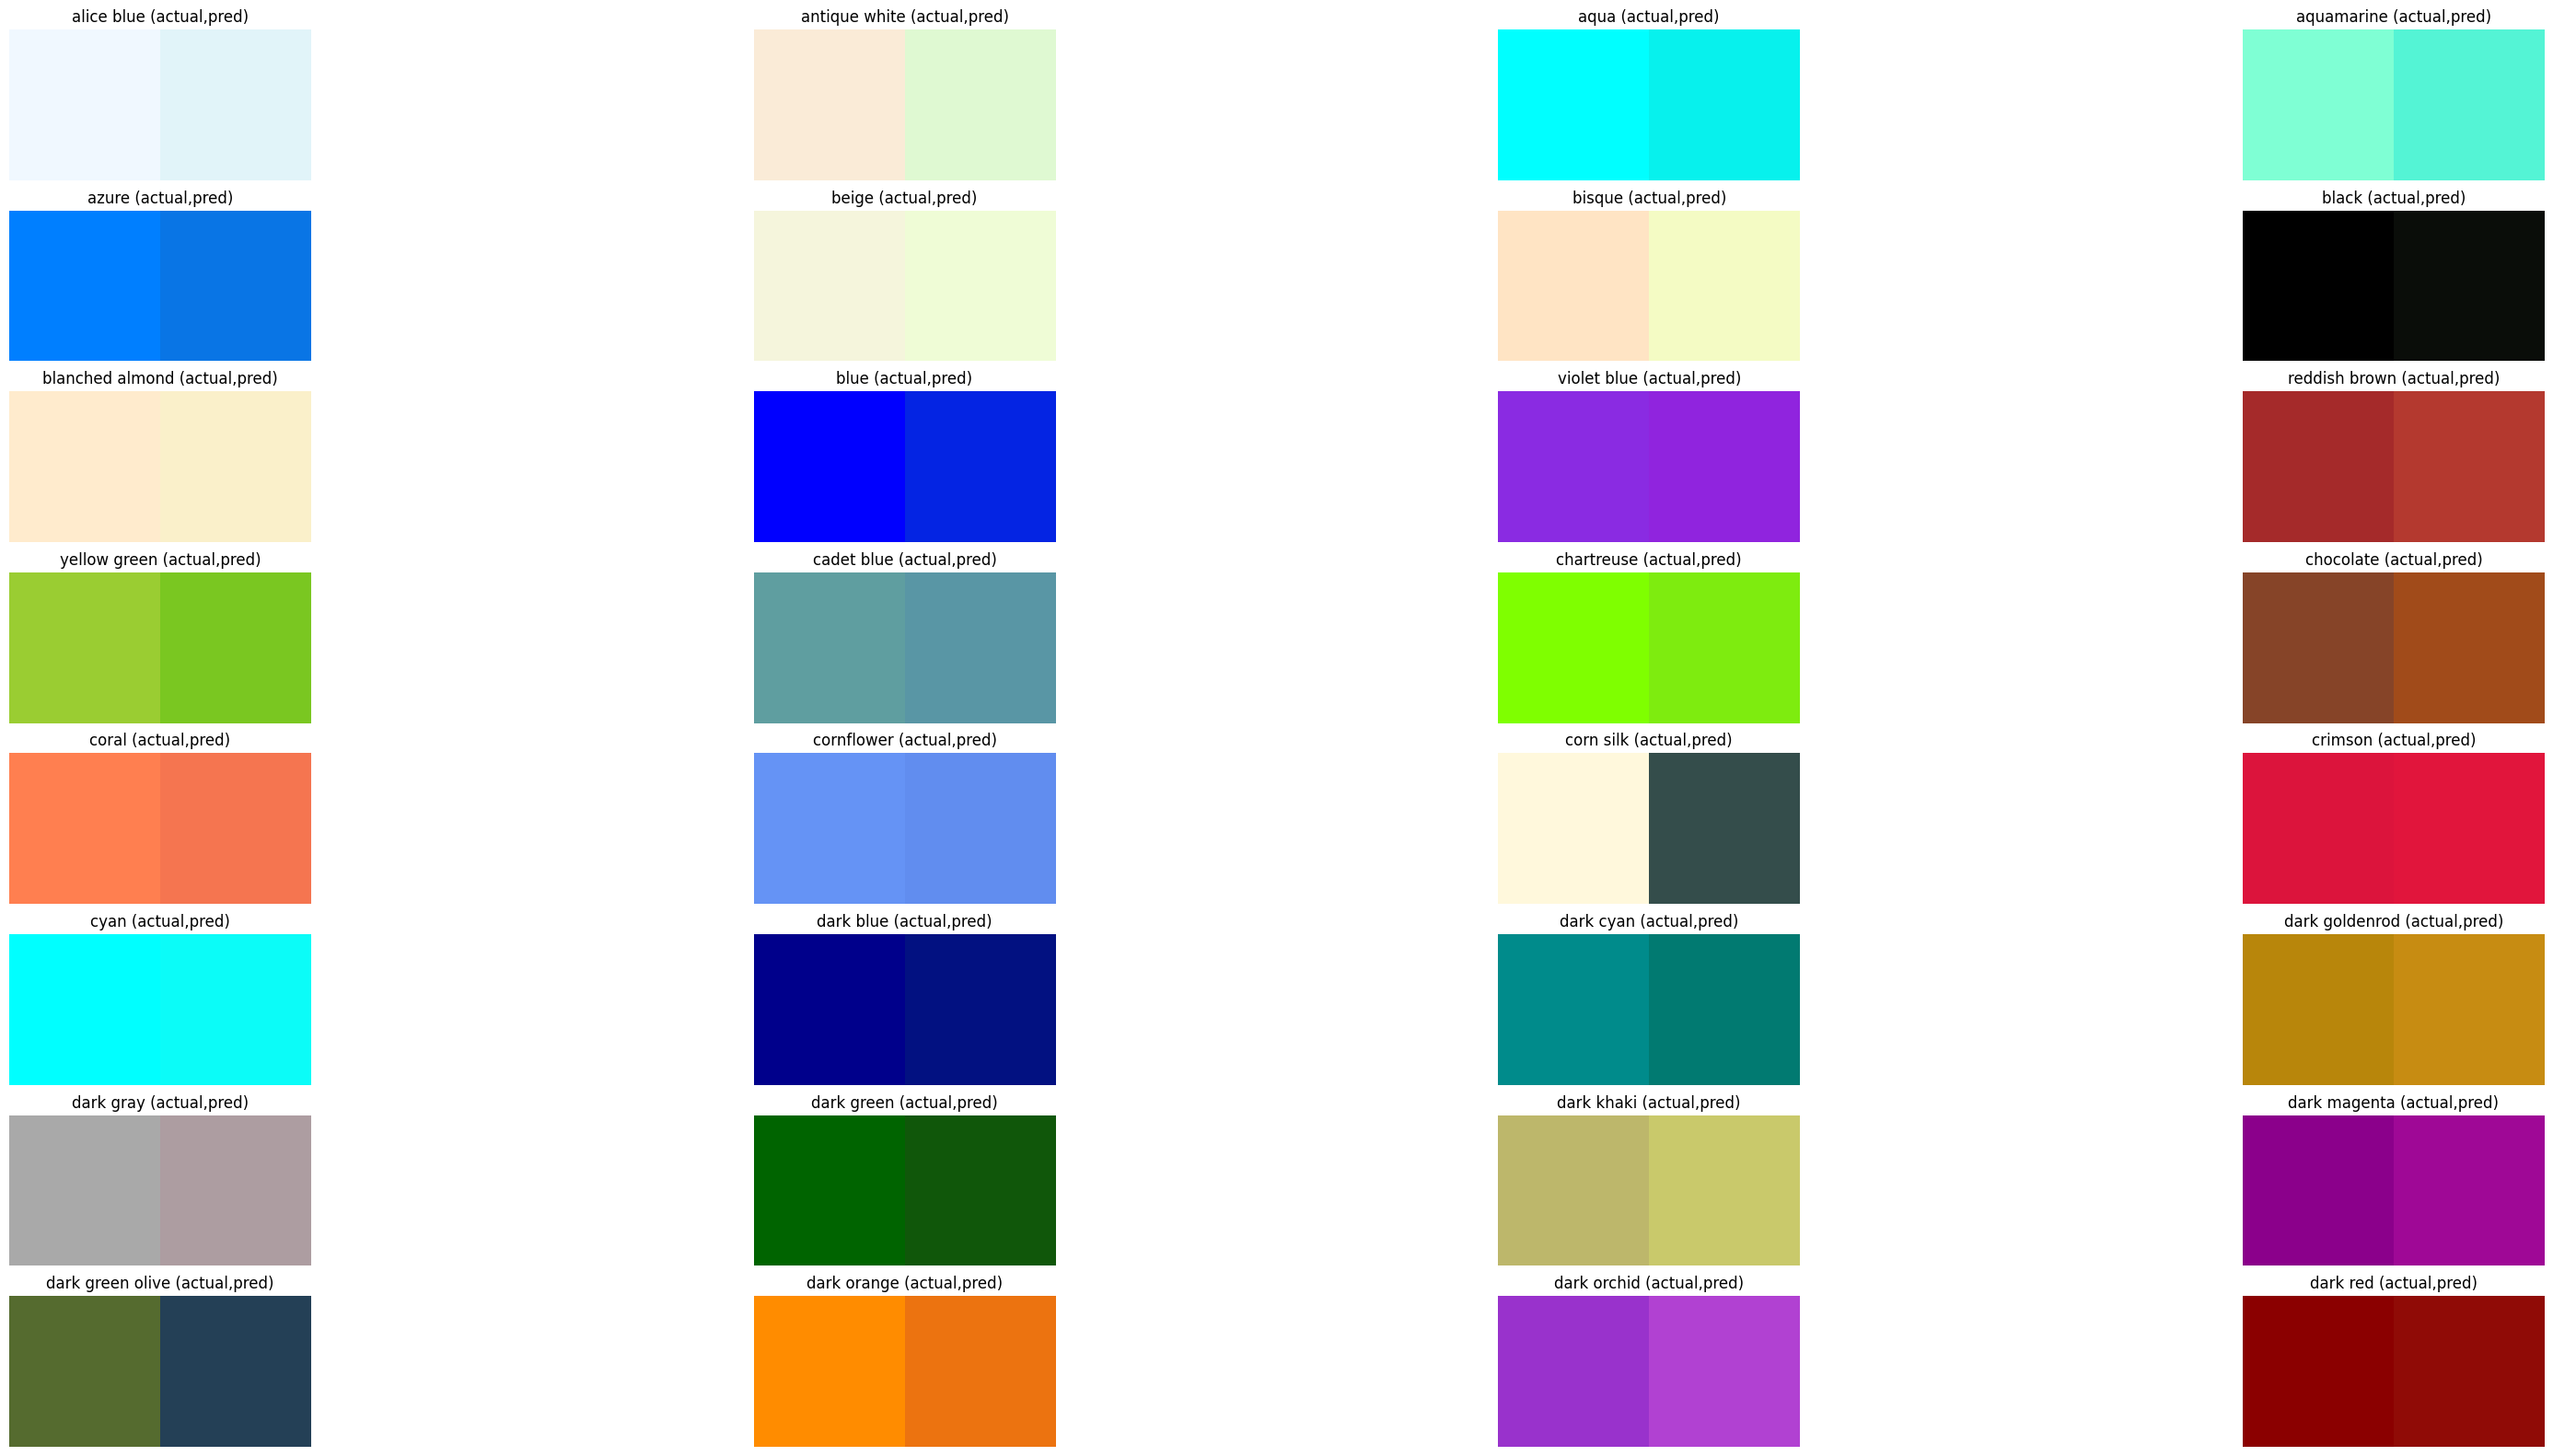

In [54]:
for data in val_ds.take(1):
    tokens=data[0].numpy()
    colors=data[1].numpy()
    y_preds=model.predict(tokens,verbose=0)
    
    cols=4
    rows=math.ceil(len(tokens)/cols)
    size=5

    fig=plt.figure(figsize=(size*rows,size*cols))

    for idx in range(len(tokens)):
        name_str=one_hot_tokens_to_str(tokens[idx])
        color=(colors[idx]*255).astype("uint8")
        pred_color=(y_preds[idx]*255).astype("uint8")
        
        fig.add_subplot(rows,cols,idx+1)    
        plot_compare_example(name_str+" (actual,pred)",color,pred_color)
    
    plt.show()

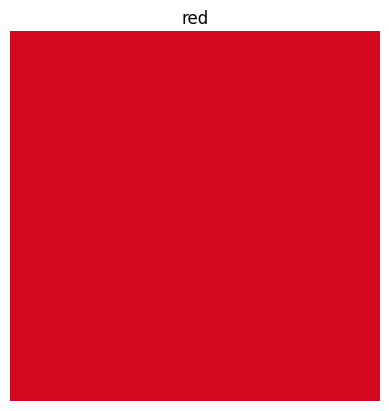

In [58]:
def test_predict_show(names):
    test_data=preprocess(names)
    colors=(model.predict(test_data,verbose=0) * 255.0).astype("uint8")
    
    for idx in range(len(names)):
        plot_single_example(names[idx],colors[idx])
        plt.show()

test_predict_show(["red"])

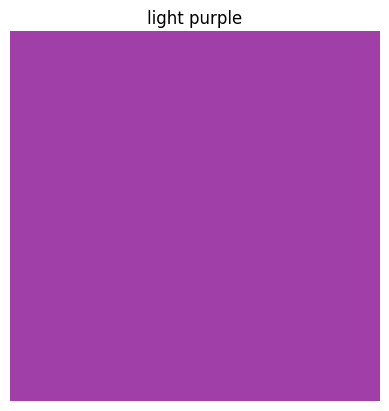

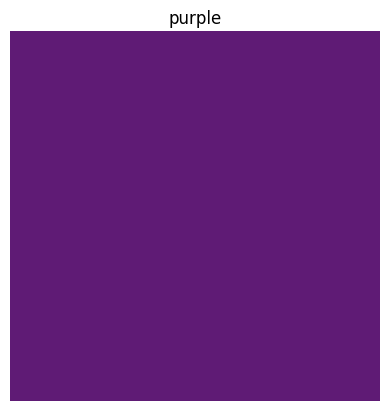

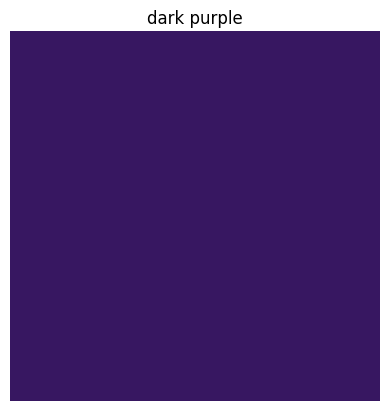

In [59]:
test_predict_show(["light purple","purple","dark purple"])

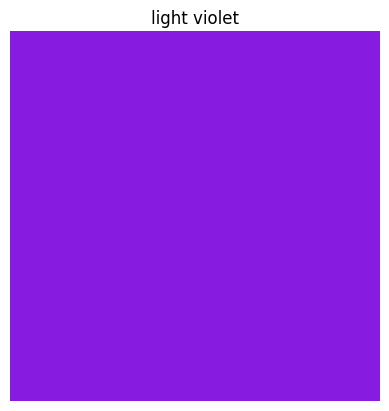

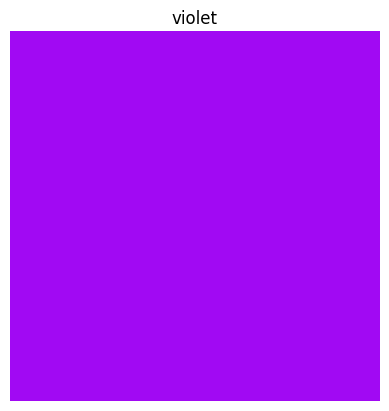

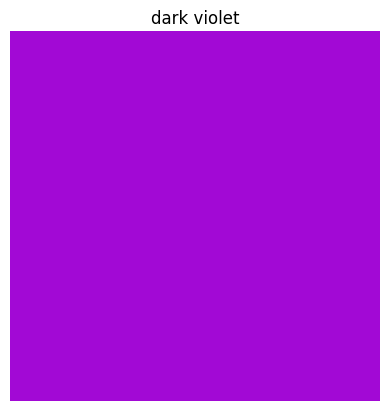

In [60]:
test_predict_show(["light violet","violet","dark violet"])

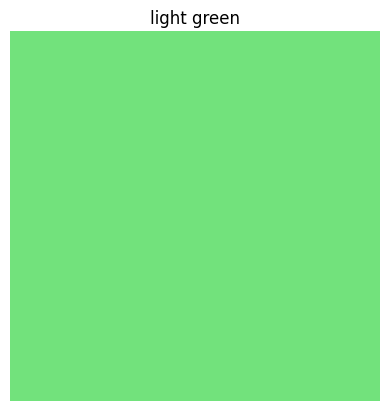

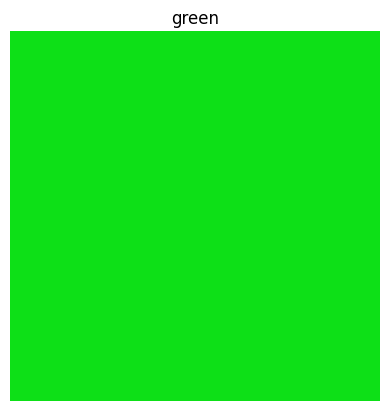

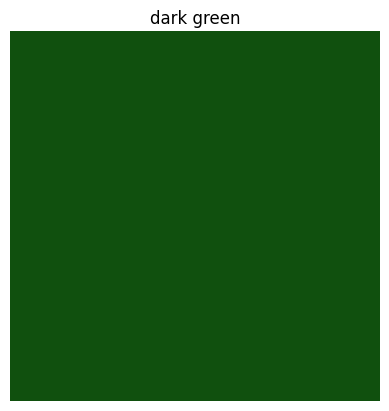

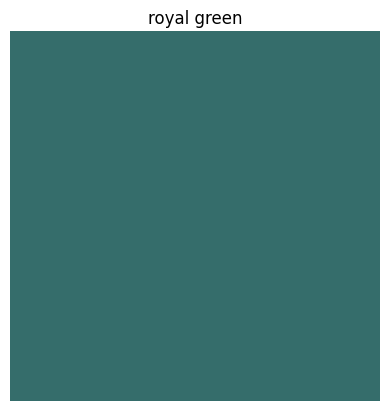

In [61]:
test_predict_show(["light green","green","dark green","royal green"])

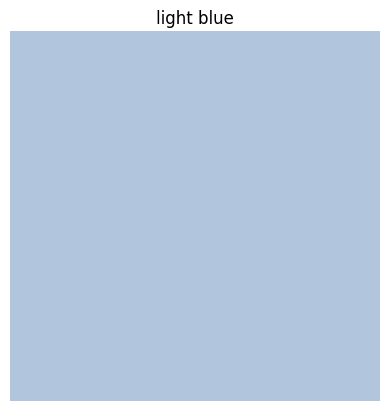

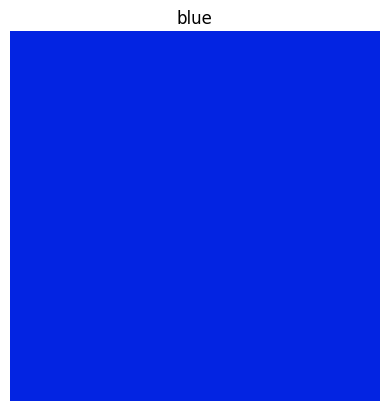

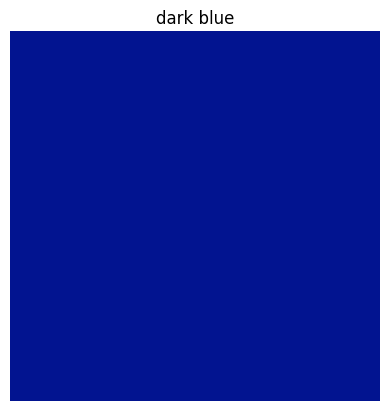

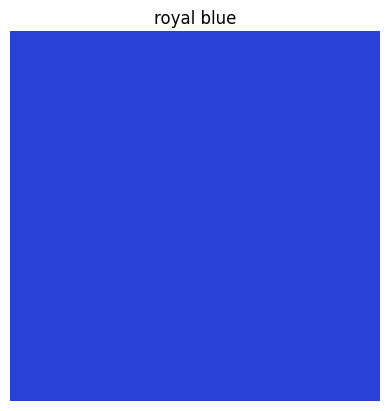

In [62]:
test_predict_show(["light blue","blue","dark blue","royal blue"])

## Exporting the model and token_dict

In [63]:
save_dir = "models/colgen1/v2/"

In [64]:
import json

model.save(save_dir+"model.h5")
with open(save_dir+"token_to_idx.txt","w") as f:
    json.dump(token_to_idx,f,indent=4)

c:\Users\panth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
